In [6]:
import sys
sys.path.append("../../")

from didgelab.util.didge_visualizer import DidgeVisualizer
import numpy as np

<AxesSubplot: xlabel='x', ylabel='y'>

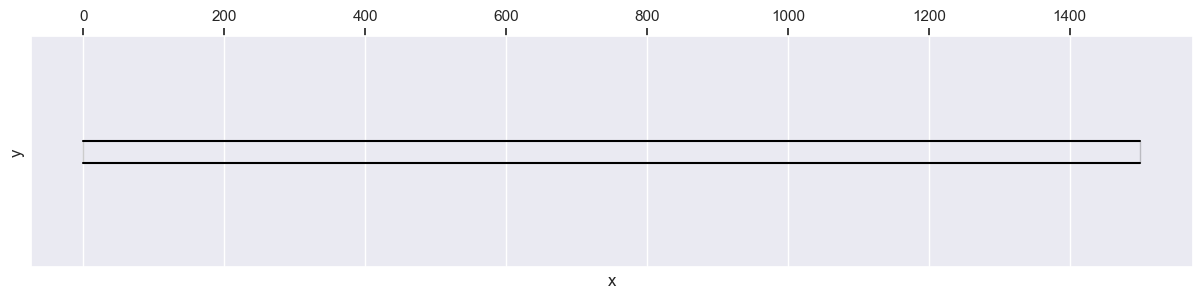

In [2]:
from abc import ABC, abstractmethod
from didgelab.evo.parameters import MutationParameterSet
from argparse import Namespace
from didgelab.calc.geo import Geo

boundaries = Namespace(
    min_length=1000,
    max_length=2000,
    max_bell_diameter=150,
    d1=32
)

class Shape(MutationParameterSet):

    def __init__(self):
        MutationParameterSet.__init__(self)

class Cylinder(Shape):
    
    def __init__(self):
        Shape.__init__(self)
        self.add_param("length", boundaries.min_length, boundaries.max_length)
        self.add_param("bell_size", boundaries.d1, boundaries.max_bell_diameter)
        
    def make_geo(self):
        geo = [[0,boundaries.d1], [self.get_value("length"), self.get_value("bell_size")]]
        return Geo(geo)
    
class Cone(Shape):
    
    def __init__(self):
        Shape.__init__(self)
        self.add_param("length", boundaries.min_length, boundaries.max_length)
        self.add_param("bell_size", boundaries.min_length, boundaries.max_length)
        
    def make_geo(self):
        geo = [[0,boundaries.d1], [self.get_value("length"), boundaries.d1]]
        return Geo(geo)
    
    
class Individual:
    
    def __init__(self, d1=32):
        
        self.d1 = d1
        self.shapes = []
        
    def add_shape(self, shape : Shape):
        self.shapes.append(shape)
        
geo=Cylinder().make_geo()
geo = [[0,32], [1500,32]]
DidgeVisualizer.vis_didge(Geo(geo))

In [7]:
class MultiSegmentShape(Shape):
    
    def __init__(self, father_geo=None):
        Shape.__init__(self)
        
        if father_geo is None:
            # create new multisegment shape
            average_length = 1500
            self.n_params = 40
            average_bell_size=75
            self.d1 = 32

            minx = 0.9*average_length/self.n_params
            maxx = 1.1*average_length/self.n_params
            mind = -1.0*(average_bell_size-self.d1)/self.n_params
            maxd = 3.0*(average_bell_size-self.d1)/self.n_params
            for i in range(self.n_params):
                self.add_param(f"x{i}", minx, maxx)
                self.add_param(f"d{i}", mind, maxd)
        else:
            # initialize it from the father
            self.n_params = len(father_geo)-1
            self.d1 = father_geo[0][1]
            for i in range(len(father_geo)-1):
                x = father_geo[i+1][0] - father_geo[i][0]
                d = father_geo[i+1][1] - father_geo[i][1]
                self.add_param(f"x{i}", 0.9*x, 1.1*x, x)
                self.add_param(f"d{i}", 0.9*d, 1.1*d, d)

    def make_geo(self):
        geo = [[0, self.d1]]
        for i in range(self.n_params):
            x=self.get_value(f"x{i}") + geo[i][0] 
            d=self.get_value(f"d{i}") + geo[i][1]
            if d<0.5*self.d1:
                d=0.5*self.d1
            geo.append([x,d])
        return Geo(geo)

geo = [[0,32], [1200, 34], [1400, 50], [1600, 60]]
shape=MultiSegmentShape(geo)
shape.make_geo().geo
#shape=MultiSegmentShape()
#mutator = MutateOperator(1.0, 1.0, True)
#mutator.mutate(shape)
#geo = shape.make_geo()
#DidgeVisualizer.vis_didge(geo)

[[0, 32], [1200, 34], [1400, 50], [1600, 60]]

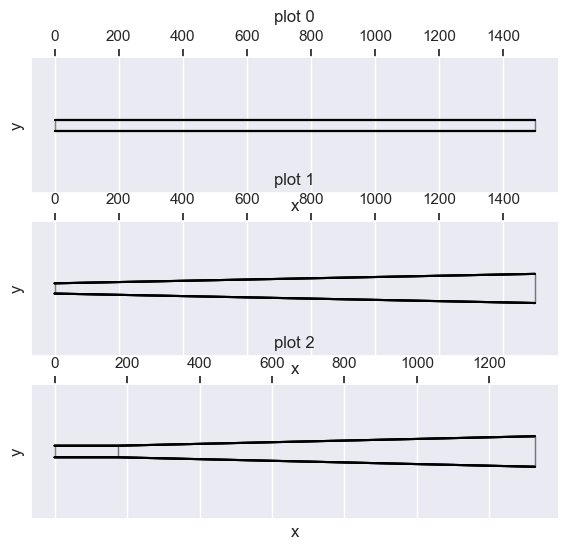

In [9]:
def crossover(shape1, shape2):
    crossx = np.random.random()
    geo1 = shape1.make_geo()
    geo2 = shape2.make_geo()
    crossx1 = crossx*geo1.geo[-1][0]
    crossx2 = crossx*geo2.geo[-1][0]
    
    geo1.geo.append([crossx1, geo1.diameter_at_x(crossx1)])
    geo2.geo.append([crossx1, geo2.diameter_at_x(crossx2)])

    geo1 = list(filter(lambda x : x[0] <= crossx1, geo1.geo))
    geo2 = list(filter(lambda x : x[0] >= crossx2, geo2.geo))
    
    geo2 = sorted(geo2, key=lambda x : x[0])
    geo2 = [[x[0]-geo1[-1][0], x[1] - (geo2[0][1] - geo1[-1][1])] for x in geo2[1:]] 
    
    new_geo = geo1
    new_geo.extend(geo2)

    return MultiSegmentShape(new_geo)
    
shape2 = Cylinder()
shape1 = Cone()
shape3 = crossover(shape1, shape2)
shape3.make_geo().geo

geos = [shape1.make_geo(), shape2.make_geo(), shape3.make_geo()]
DidgeVisualizer.vis_didge(geos)

In [12]:
print(geos[0].geo)
print(geos[1].geo)
print(geos[2].geo)

[[0, 32], [1500.0, 32]]
[[0, 32], [1500.0, 91.0]]
[[0, 32], [174.2521020251011, 32.0], [1325.747897974899, 84.14608398701269]]


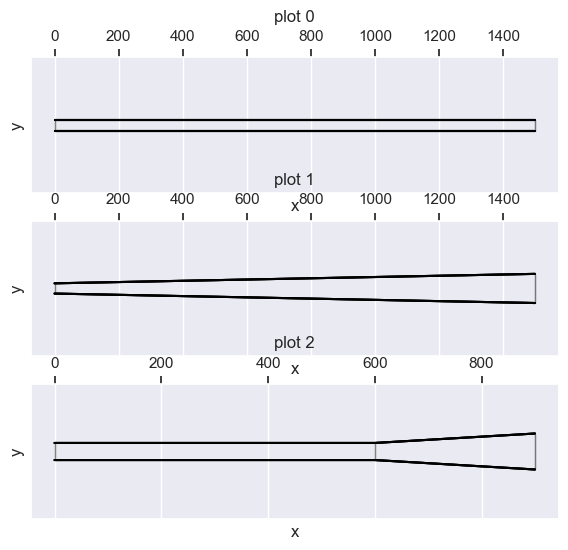

In [109]:
def vis_didge(geo):
    
    if type(geo) == list:
        plt.figure(figsize=(15,2*len(geo)))
        for g in geo:
            for i in range(len(geo)):
                plt.subplot(len(geo), 2, 2*i+1)
                DidgeVisualizer.vis_didge(geo[i])
                plt.title("plot " + str(i))
            

    else:
        df=DidgeVisualizer.create_didge_shape(geo)
        n_series=len(df["series"].unique())
        palette = ["#000000"]*n_series
        sns.set(rc={'figure.figsize':(15,3)})
        g=sns.lineplot(data=df, x="x", y="y", hue="series", palette=palette)
        g.set(ylim=(0, df["y"].max()))
        g.set(xlim=(0, df["x"].max()))
        g.get_legend().remove()
        g.set_yticks([])
        g.xaxis.set_ticks_position("top")
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.axis('equal')
        return g

geos = [shape1.make_geo(), shape2.make_geo(), shape3.make_geo()]
vis_didge(geos)

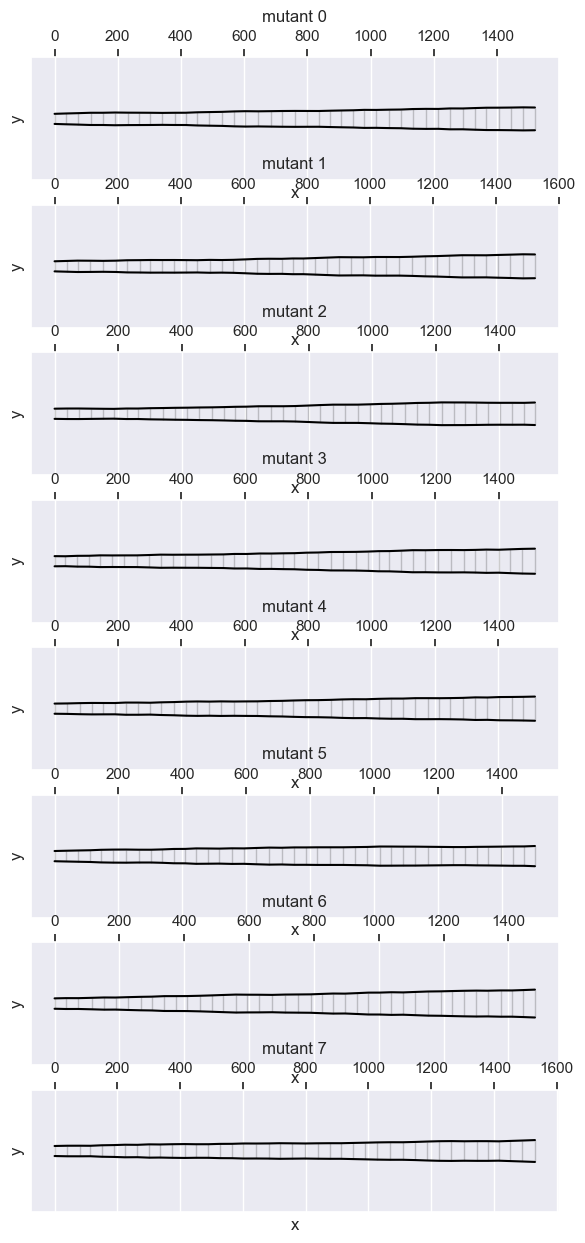

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from didgelab.evo.operators import MutateOperator

plt.figure(figsize=(15,15))
n_mutants = 8
parameters = MultiSegmentShape()
mutator = MutateOperator(1.0, 1.0, True)
for i in range(n_mutants):
    plt.subplot(n_mutants, 2, 2*i+1)
    mutant = parameters.copy()
    mutator.mutate(mutant)
    geo = mutant.make_geo()
    DidgeVisualizer.vis_didge(geo)
    plt.title("mutant " + str(i))


In [ ]:
*